<a href="https://colab.research.google.com/github/LucaB999/Market_Basket_Analysis/blob/main/MBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup



In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

In [3]:
!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
sc = spark.sparkContext

In [25]:
import pandas as pd
import numpy as np
from itertools import product, combinations, chain

# Import MeDAL dataset

In [7]:
# Insert your own kaggle keys
os.environ['KAGGLE_USERNAME'] = "lucabertoletti"
os.environ['KAGGLE_KEY'] = "c2911d38c556ca0e3ff784f636ff6924"
!kaggle datasets download -d xhlulu/medal-emnlp --unzip

100% 6.82G/6.82G [01:23<00:00, 76.0MB/s]
100% 6.82G/6.82G [01:23<00:00, 87.5MB/s]


In [8]:
# Read the dataset
df = spark.read.csv("full_data.csv", header = True, sep=",")

# Preview of the dataset
#df.show()

In [9]:
# Take a subset
subset = df.sample(False,0.001,seed = 33)

In [10]:
# Convert the subset to rdd and take only the column 'text'
rdd = subset.rdd.map(lambda x: x[0])

In [11]:
rdd.take(1)

['patients suffering from various functional abdominal complaints have been trated in a x doubleblind design a psychotherapy with ro thro b psychotherapy with placebo thp c ro without psychotherapy nihro d placebo without psychotherapy nthp results show that a considerable amount of improvement cannot be ascribed to the two critical AF or the interaction of both but are due to unspecific influences in the course of treatment some of the results concerning the combination of th and the psychotropic drug pose interesting questions for further research and bare implications for doubleblind trials of psychotropic drugs the results suggest that possibly properties of any psychotropic drug have to be related to a doctorpatient relationship within which the personal problems of the patient are dealt with in order to evaluate such properties special methodological precautions have to be taken these will be briefly discussed']

# Pre-processing Data

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    from nltk.corpus import stopwords
    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return list(set(tokens))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
# Apply preprocess_text to the rdd
rdd = rdd.map(preprocess_text)

In [14]:
rdd.take(1)

[['result',
  'course',
  'x',
  'pose',
  'th',
  'dealt',
  'nthp',
  'bare',
  'critical',
  'functional',
  'c',
  'relationship',
  'interaction',
  'within',
  'doctorpatient',
  'thro',
  'placebo',
  'doubleblind',
  'unspecific',
  'evaluate',
  'precaution',
  'amount',
  'combination',
  'trated',
  'methodological',
  'implication',
  'nihro',
  'drug',
  'thp',
  'possibly',
  'special',
  'related',
  'af',
  'property',
  'complaint',
  'various',
  'psychotropic',
  'patient',
  'treatment',
  'order',
  'psychotherapy',
  'considerable',
  'influence',
  'ro',
  'abdominal',
  'concerning',
  'interesting',
  'design',
  'b',
  'problem',
  'two',
  'question',
  'research',
  'briefly',
  'taken',
  'personal',
  'without',
  'show',
  'improvement',
  'suggest',
  'suffering',
  'discussed',
  'ascribed',
  'trial',
  'due']]

In [15]:
def create_vocabulary(rdd):

    # Assign a index to each word
    i2w = rdd.flatMap(lambda line:line)\
                      .distinct().zipWithIndex()\
                      .map(lambda x: (x[1], x[0]))\
                      .collectAsMap()


    # Reverse the key, value pairs
    w2i = {value:key for key, value in i2w.items()}

    return i2w, w2i

In [16]:
# Create the vocabularies
i2w, w2i = create_vocabulary(rdd)

In [17]:
# Substitute each word by its corresponding index
def create_indexing(rdd, w2i):
 return rdd.map(lambda sentence: [w2i[word] for word in sentence])

In [18]:
rdd = create_indexing(rdd, w2i)

# A-priori Algorithm

In [26]:
#Define the 'new_combinations' function that takes an rdd (items) containing the result of the
#function apriori at step i-1 and the index i which indicates the size of the
#combinations of words (starts from i=3 for triples).
#The function generates the singletons from "items" and evaluate the carthesian product
#between "items" and the singletons.
#Returns the combinations which have size = i removing every possible permutation.

def new_combinations(items, i):
  #removes the counter from each item
  items = items.map(lambda item: list(item[0]))
  #generate singletons from each item in items
  singletons = items.flatMap(list)\
                    .map(lambda item:(item,1))\
                    .reduceByKey(lambda x,y: x+y)\
                    .map(lambda item:item[0])
  #create an empty list that will contain the new possible combinations
  items_set = []
  #for cicle generates the new combinations using the Cartesian product between items and singletons
  for comb in list(product(items.toLocalIterator(), singletons.toLocalIterator())):
    #merges the two lists into a "new item" with form "new item"=[item, singleton]
    #comb = comb[0]+comb[1]
    comb = chain(comb[0], [comb[1]])
    #take the set of each combination and sort it to prevent permutations to
    #be counted as different item and to remove the repetitions of words
    comb_set = sorted(set().union(comb))
    #if the set has size = i and was not already included in items_set
    #then it is added to items_set
    if (len(comb_set) == i) and comb_set not in items_set:
        items_set.append(comb_set)
  return items_set

In [27]:
#Define the apriori function that takes as parameters an rdd and the minumum support (threshold) to evaluate the frequent pairs, triples etc.
#Returns an rdd (results) containing all the frequent items and their occurrencies

def apriori(rdd, threshold):
  #create 'results' as an empty rdd
  results = sc.parallelize([])

  #generate frequent singletons
  singletons = rdd.flatMap(list)\
                  .map(lambda item: (item,1))\
                  .reduceByKey(lambda x,y: x+y)\
                  .filter(lambda item: item[1] >= threshold)

  #add frequent singletons
  results = results.union(singletons)

  singletons = singletons.map(lambda x: x[0])

  #find the possible pairs
  possible_combinations = list(combinations(singletons.toLocalIterator(),2))

  i=3 #size of candidates

  while len(possible_combinations)>0:

    #check whether the possible items are frequent
    frequent_items = rdd.flatMap(lambda sentence: [(tuple(item), 1) for item in possible_combinations if set(list(item)).issubset(set(sentence))]) \
                    .reduceByKey(lambda x, y: x+y) \
                    .filter(lambda item: item[1] >= threshold)
    #add the frequent items and their occurrencies to results
    results = results.union(frequent_items)

    #generates new items from the last frequent items found using the function defined above
    possible_combinations = new_combinations(frequent_items, i)

    #increment i
    i += 1

  return results

In [21]:
#compute the threshold (min support) using 0.03 as fraction of the number of baskets
#in order for pairs, triple, ecc. to be considered frequent
count = rdd.count()
threshold = count*0.03
print(count, threshold)

14357 430.71


In [28]:
results = apriori(rdd, threshold) #run the algorithm

In [29]:
results = results.collect()

In [30]:
results

[(53449, 1605),
 (64523, 601),
 (75597, 475),
 (35370, 865),
 (54128, 568),
 (4182, 579),
 (13900, 490),
 (7572, 556),
 (61812, 1649),
 (74242, 595),
 (30511, 530),
 (18760, 563),
 (2, 641),
 (4861, 992),
 (55598, 909),
 (8251, 484),
 (61813, 697),
 (26331, 676),
 (43169, 706),
 (53452, 1716),
 (54130, 489),
 (64526, 707),
 (61814, 784),
 (61136, 531),
 (38876, 509),
 (43170, 676),
 (54131, 1582),
 (35373, 615),
 (11079, 853),
 (18763, 1054),
 (43172, 3130),
 (53455, 481),
 (11081, 1234),
 (53456, 590),
 (7578, 444),
 (15376, 433),
 (43175, 583),
 (6903, 967),
 (38882, 735),
 (53459, 570),
 (55606, 2141),
 (8260, 470),
 (38205, 558),
 (65213, 2352),
 (43178, 576),
 (63180, 3898),
 (51428, 498),
 (65214, 1989),
 (73463, 532),
 (72785, 748),
 (11087, 438),
 (28376, 1012),
 (43179, 1238),
 (65215, 1473),
 (28377, 447),
 (74934, 1686),
 (36062, 1075),
 (72787, 714),
 (43181, 716),
 (4196, 641),
 (4874, 960),
 (29057, 473),
 (11768, 542),
 (51431, 2451),
 (16, 611),
 (61827, 518),
 (52110, 

In [31]:
results = [(i2w[t[0]],t[1]) if type(t[0])==int else (tuple([i2w[element] for element in t[0]]),t[1]) for t in results] # Re-convert indexes to words

In [32]:
results

[('increase', 1605),
 ('tested', 601),
 ('direct', 475),
 ('various', 865),
 ('suggested', 568),
 ('loss', 579),
 ('regulation', 490),
 ('large', 556),
 ('significantly', 1649),
 ('via', 595),
 ('strategy', 530),
 ('discussed', 563),
 ('major', 641),
 ('reduced', 992),
 ('test', 909),
 ('muscle', 484),
 ('surface', 697),
 ('previously', 676),
 ('property', 706),
 ('control', 1716),
 ('dose', 489),
 ('contrast', 707),
 ('c2', 784),
 ('often', 531),
 ('combination', 509),
 ('order', 676),
 ('system', 1582),
 ('antibody', 615),
 ('drug', 853),
 ('respectively', 1054),
 ('effect', 3130),
 ('frequency', 481),
 ('difference', 1234),
 ('membrane', 590),
 ('culture', 444),
 ('correlated', 433),
 ('required', 583),
 ('shown', 967),
 ('evaluated', 735),
 ('therapeutic', 570),
 ('analysis', 2141),
 ('severe', 470),
 ('cf', 558),
 ('treatment', 2352),
 ('indicated', 576),
 ('result', 3898),
 ('af', 498),
 ('different', 1989),
 ('ratio', 532),
 ('four', 748),
 ('included', 438),
 ('reported', 1012)

# Number of itemsets for each size

In [33]:
from collections import defaultdict

# Count the number of occurences for each size
pair_counts = defaultdict(int) # default value as zero
for item, freq in results:
    if isinstance(item, tuple):  # checks if the item is a pair of items
        pair_length = len(item)
        pair_counts[pair_length] += 1
    else:                        # if the item is not a tuple, it means it's a single item
        pair_counts[1] += 1

# Show results
for pair_length, count in pair_counts.items():
    print(f"{pair_length}-word: {count} occurrences")

1-word: 383 occurrences
2-word: 393 occurrences
3-word: 2 occurrences


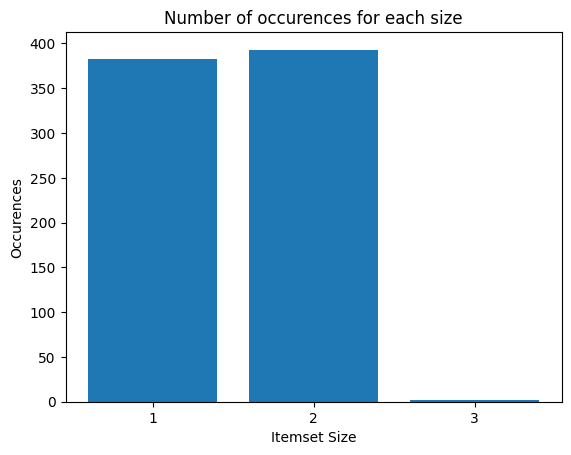

In [34]:
import matplotlib.pyplot as plt

pair_lengths = list(pair_counts.keys()) # extract the keys (pair lengths) from the pair_counts dictionary and convert them into a list
pair_frequency = list(pair_counts.values()) # extract the values (occurrences counts) from the pair_counts dictionary and convert them into a list

# Plot
plt.bar(pair_lengths, pair_frequency)
plt.xlabel('Itemset Size')
plt.ylabel('Occurences')
plt.title('Number of occurences for each size')
plt.xticks(pair_lengths)
plt.show()

# Computation time with increasing threshold

In [35]:
#Sampling for ratio threshold over time
#analyze the time needed by the algorithm by varying the minimum support

import time

sample = rdd.sample(False, 0.25, seed = 23)
#create a list which will contain the elapsed time for each threshold
elapsed = []
#create a list which will contain the frequent items for each threshold
frequent = []
#count the number of baskets to compute the minimum support
count = sample.count()
#will contain the support size in the format t*0,01
threshold_ap = []
for t in range(3,9):
  #save the start time
  start = time.time()
  #compute the support size
  threshold_perc = t*0.01
  threshold_ap.append(threshold_perc)
  #perform apriori on the sample using as support threshold_perc*count
  frequent.append(list(apriori(sample, threshold_perc*count).collect()))
  #save the end time
  end = time.time()
  #calculate the elapsed time
  interval = end - start
  elapsed.append(interval)

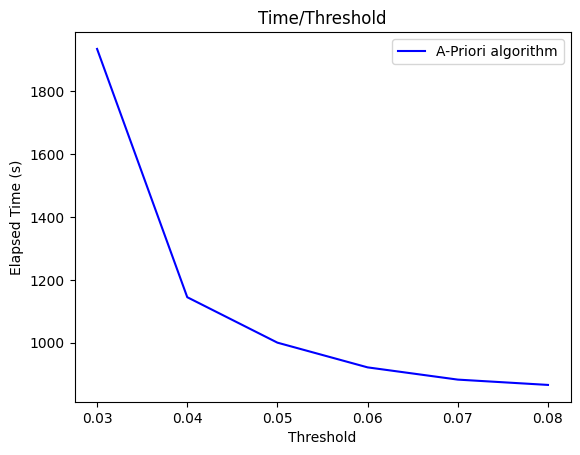

In [36]:
#apriori plot for threshold size between 0.03 and 0.08 on 25% size sample
import matplotlib.pyplot as plt

time_threshold_ratio = pd.DataFrame() # Create an empty df
time_threshold_ratio['Elapsed_time'] = elapsed # add column 'elapsed time'
time_threshold_ratio['Threshold'] = threshold_ap # add column 'threshold'
plt.plot(time_threshold_ratio['Threshold'], time_threshold_ratio['Elapsed_time'],
         label = 'A-Priori algorithm', color = 'blue')
plt.xlabel('Threshold')
plt.ylabel('Elapsed Time (s)')
plt.legend()
plt.title('Time/Threshold')
plt.show()